In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


## Accuracy

Training set size: 73037 samples
Test set size: 18260 samples
Accuracy: 0.9541


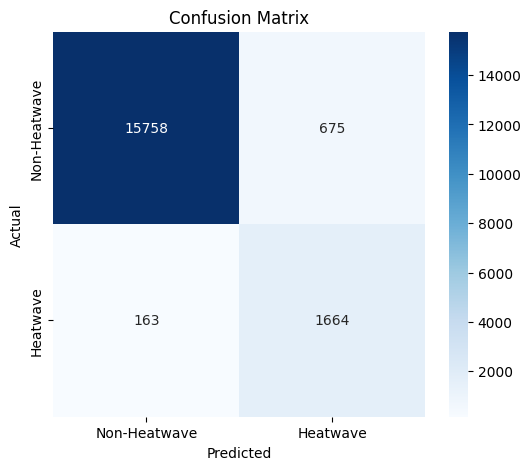

Confusion Matrix:
[[15758   675]
 [  163  1664]]


In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

# Function to prepare the Sindh heatwave data (this is your existing function)
def prepare_sindh_heatwave_data(df):
    # Convert date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Select features for modeling
    features = [
        # Meteorological features
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',

        # Time-based features
        'month', 'day_of_year', 'season',

        # Rolling averages
        'temp_7d_avg', 'temp_14d_avg',

        # Reference feature
        'heatwave_threshold'
    ]

    X = df[features]
    y = df['is_heatwave_day']

    return X, y

# Load the saved model
model = joblib.load('/content/drive/MyDrive/FYP/processed_data/heatwave_kpk_XGB.pkl')

# Prepare the dataset (assuming df is your full Sindh dataset)
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet')

# Prepare the features and target variable
X, y = prepare_sindh_heatwave_data(df)

# Split the data into training and testing sets (80% train, 20% test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Ensure the test set is separated correctly from the train set
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get probabilities for the positive class (heatwave)
y_proba = model.predict_proba(X_test)[:, 1]

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Heatwave', 'Heatwave'], yticklabels=['Non-Heatwave', 'Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

##Training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet')
df = df.dropna(subset=['et0_fao_evapotranspiration'])

def prepare_sindh_heatwave_data(df):
    # Convert date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Select features for modeling
    features = [
        # Meteorological features
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',

        # Time-based features
        'month', 'day_of_year', 'season',

        # Rolling averages
        'temp_7d_avg', 'temp_14d_avg',

        # Reference feature
        'heatwave_threshold'
    ]

    # You could add grid_id as a feature if you want to distinguish locations
    # features.append('grid_id')

    X = df[features]
    y = df['is_heatwave_day']

    return X, y, df['date']

def create_heatwave_pipeline():
    # Define feature types
    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipeline with XGBoost (generally performs well for this type of problem)
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(
            scale_pos_weight=33,
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        ))
    ])

    return pipeline

def evaluate_heatwave_model(pipeline, X_test, y_test):
    # Get predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Calculate precision-recall metrics
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    print(f"\nAverage Precision Score: {avg_prec:.4f}")

    # Find optimal threshold (F1 score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # Recompute predictions with optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))

    return y_pred, y_proba, optimal_threshold

def feature_importance_analysis(pipeline, X):
    # Extract feature names
    preprocessor = pipeline.named_steps['preprocessor']

    # Get numeric feature names
    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    # Get categorical feature names after one-hot encoding
    categorical_features = ['month', 'season']
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))

    # Combine all feature names
    feature_names = numeric_features + cat_feature_names

    # Get feature importances from model
    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_

    # Create features importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df.head(10))

    return importance_df

def hyperparameter_tuning(X_train, y_train):
    # Define grid search parameters for XGBoost
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__gamma': [0, 0.1, 0.2],
        'classifier__min_child_weight': [1, 3, 5]
    }

    # Create pipeline
    pipeline = create_heatwave_pipeline()

    # Create time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Create grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='average_precision',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print("\nBest Parameters:")
    print(grid_search.best_params_)
    print(f"Best Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def main(df):
    # Prepare data
    X, y, dates = prepare_sindh_heatwave_data(df)

    # Print class distribution
    print("Class Distribution:")
    print(y.value_counts(normalize=True))

    # Create a time-based train-test split (more realistic for forecasting)
    # Using approximately the last 20% of data as test set
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Option 1: Train a simple model
    pipeline = create_heatwave_pipeline()
    pipeline.fit(X_train, y_train)

    # Evaluate model
    y_pred, y_proba, optimal_threshold = evaluate_heatwave_model(pipeline, X_test, y_test)

    # Feature importance analysis
    importance_df = feature_importance_analysis(pipeline, X)

    # Option 2: Hyperparameter tuning (uncomment to run - will take time)
    # best_model = hyperparameter_tuning(X_train, y_train)
    # y_pred_best, y_proba_best, _ = evaluate_heatwave_model(best_model, X_test, y_test)

    return pipeline, importance_df, optimal_threshold

# Usage example:
# df = pd.read_parquet('sindh_weather_data.parquet')
model, feature_importance, threshold = main(df)

### Save the model

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")  # Update path if needed


['/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl']

### Filtering Karachi from dataset

In [ ]:
df_karachi = df[df["grid_id"] == 4 ]
df_karachi

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,grid_id,year,month,day,day_of_year,week_of_year,season,temp_7d_avg,temp_14d_avg,heatwave_threshold,is_heatwave_day,heatwave_final
27339,1999-12-31 19:00:00+00:00,20.130583,0.0,28.167557,49.611752,16.620001,6.051518,4,1999,12,31,365,52,Winter,17.277869,16.829626,21.921343,0,0
27340,2000-01-01 19:00:00+00:00,20.341002,0.0,25.772078,47.664616,16.430000,5.722839,4,2000,1,1,1,52,Winter,18.695393,18.027303,20.383333,0,0
27341,2000-01-02 19:00:00+00:00,19.978502,0.0,20.620804,40.500660,16.500000,4.687050,4,2000,1,2,2,52,Winter,17.592606,17.912452,20.383333,0,0
27342,2000-01-03 19:00:00+00:00,18.699335,0.0,13.044722,5.488949,16.590000,3.950572,4,2000,1,3,3,1,Winter,17.093179,16.949363,20.383333,0,0
27343,2000-01-04 19:00:00+00:00,19.053499,0.0,15.192682,43.225933,16.680000,3.944164,4,2000,1,4,4,1,Winter,17.510702,17.243357,20.383333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36447,2024-12-07 19:00:00+00:00,20.594168,0.0,19.240644,339.833618,16.040001,5.486357,4,2024,12,7,342,49,Winter,18.159512,18.199464,21.921343,0,0
36448,2024-12-08 19:00:00+00:00,18.300417,0.0,11.352850,21.914925,15.850000,3.756150,4,2024,12,8,343,49,Winter,16.401631,16.623994,21.921343,0,0
36449,2024-12-09 19:00:00+00:00,18.167084,0.0,11.448055,43.174313,15.650000,3.811638,4,2024,12,9,344,50,Winter,17.021036,17.195917,21.921343,0,0
36450,2024-12-10 19:00:00+00:00,17.662916,0.0,9.044888,35.192703,15.320000,3.404733,4,2024,12,10,345,50,Winter,17.720215,16.994560,21.921343,0,0


### Verifying prediction from historical data
18-24 June 2015
18,21,22 june 2024

In [ ]:
import joblib
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

import pandas as pd

# Load dataset again (if needed)
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet')
df = df_karachi.dropna(subset=['et0_fao_evapotranspiration'])

# Step 1: Sort by date
df = df.sort_values(by="date")

# Step 2: Compute rolling averages
#df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
#df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Step 3: Filter for June 18-24, 2024
df_june = df[(df["date"] >= "2015-06-15") & (df["date"] <= "2015-06-25")]

# Drop the target variable (if present)
X_new = df_june.drop(columns=["is_heatwave_day"], errors="ignore")

# Step 4: Apply the same preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Step 5: Predict
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Step 6: Add predictions to DataFrame
df_june["predicted_heatwave"] = predictions

# Step 7: Show results
df_june[["date", "temperature_2m_mean", "predicted_heatwave"]]





<ipython-input-20-51e5fba2fb01>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june["predicted_heatwave"] = predictions


,date,temperature_2m_mean,predicted_heatwave
32984,2015-06-15 19:00:00+00:00,30.297255,0
32985,2015-06-16 19:00:00+00:00,30.976418,0
32986,2015-06-17 19:00:00+00:00,31.855585,1
32987,2015-06-18 19:00:00+00:00,32.630581,0
32988,2015-06-19 19:00:00+00:00,33.655582,1
32989,2015-06-20 19:00:00+00:00,35.628498,1
32990,2015-06-21 19:00:00+00:00,35.655582,1
32991,2015-06-22 19:00:00+00:00,33.818089,1
32992,2015-06-23 19:00:00+00:00,30.630585,1
32993,2015-06-24 19:00:00+00:00,31.061834,1


### Verifying from cleaned data

In [ ]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

# Load Grid 4 data
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_sindh/Grid_4_daily_sindh.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date
df = df.sort_values(by="date")

df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Drop rows where 'et0_fao_evapotranspiration' is missing
df = df.dropna(subset=['et0_fao_evapotranspiration'])

# Feature Engineering: Add Missing Features
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear

# Map seasons (based on your previous work)
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Load Sindh-wide dataset to get original heatwave threshold
#sindh_df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet')

# Get the heatwave threshold used in training
global_heatwave_threshold = sindh_df["heatwave_threshold"].unique()[0]

# Apply this fixed threshold to Grid 4
df["heatwave_threshold"] = global_heatwave_threshold

# Filter for June 18-24, 2024
df_filtered = df[(df["date"] >= "2015-06-01") & (df["date"] <= "2015-06-25")]

# Drop target variable if present
X_new = df_filtered.drop(columns=["is_heatwave_day"], errors="ignore")

# Apply preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Predict heatwave occurrence
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Store predictions in DataFrame
df_filtered["predicted_heatwave"] = predictions

# Show results
print(df_filtered[["date", "temperature_2m_mean", "predicted_heatwave"]])


                          date  temperature_2m_mean  predicted_heatwave
5631 2015-06-01 19:00:00+00:00            32.749332                   1
5632 2015-06-02 19:00:00+00:00            31.053500                   1
5633 2015-06-03 19:00:00+00:00            30.432670                   1
5634 2015-06-04 19:00:00+00:00            30.713915                   1
5635 2015-06-05 19:00:00+00:00            29.853502                   0
5636 2015-06-06 19:00:00+00:00            29.676420                   0
5637 2015-06-07 19:00:00+00:00            30.134750                   0
5638 2015-06-08 19:00:00+00:00            30.503500                   0
5639 2015-06-09 19:00:00+00:00            30.682665                   1
5640 2015-06-10 19:00:00+00:00            30.705584                   1
5641 2015-06-11 19:00:00+00:00            30.482672                   1
5642 2015-06-12 19:00:00+00:00            30.355589                   0
5643 2015-06-13 19:00:00+00:00            30.347252             

<ipython-input-50-fa5cf986931e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["predicted_heatwave"] = predictions


In [ ]:
print(df_filtered.dtypes)
print(df_filtered.isna().sum())  # Check for missing values
df_filtered.head()  # Show first few rows
import joblib

# Load model pipeline
pipeline = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

xgb_model = pipeline.named_steps['classifier']
print(xgb_model.get_booster().feature_names)

preprocessor = pipeline.named_steps['preprocessor']
print(preprocessor.get_feature_names_out())


['num__temperature_2m_mean' 'num__precipitation_sum'
 'num__wind_speed_10m_max' 'num__wind_direction_10m_dominant'
 'num__shortwave_radiation_sum' 'num__et0_fao_evapotranspiration'
 'num__day_of_year' 'num__temp_7d_avg' 'num__temp_14d_avg'
 'num__heatwave_threshold' 'cat__month_1' 'cat__month_2' 'cat__month_3'
 'cat__month_4' 'cat__month_5' 'cat__month_6' 'cat__month_7'
 'cat__month_8' 'cat__month_9' 'cat__month_10' 'cat__month_11'
 'cat__month_12' 'cat__season_Autumn' 'cat__season_Spring'
 'cat__season_Summer' 'cat__season_Winter']


ROC-AUC

Columns in X: Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'grid_id',
       'year', 'month', 'day', 'day_of_year', 'week_of_year', 'season',
       'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold', 'heatwave_final'],
      dtype='object')


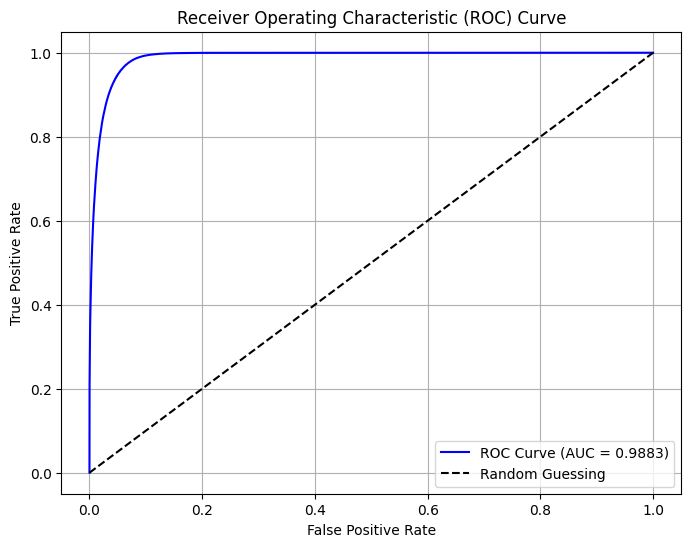

ROC-AUC Score: 0.9883


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Load trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

# Load full dataset (replace with your actual file)
df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet")

# Extract features and target
X = df.drop(columns=["is_heatwave_day"])  # Remove target column
y = df["is_heatwave_day"]  # Target variable

# Ensure feature columns match what the model expects
print("Columns in X:", X.columns)

# Get predicted probabilities for class 1 (heatwave day)
y_probs = model.predict_proba(X)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y, y_probs)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")


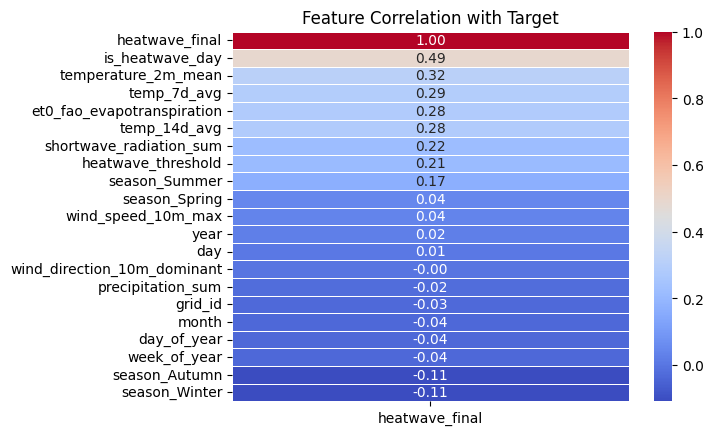

In [ ]:
# --- Import required libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# --- Load dataset ---
file_path = "/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet"  # Update if needed
df = pd.read_parquet(file_path)

# --- Drop non-numeric or unwanted columns (update if necessary) ---
df = df.drop(columns=["date"], errors="ignore")  # Drop 'date' if it exists

# --- Identify categorical and numerical columns ---
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# --- One-Hot Encode categorical variables ---
if categorical_cols:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_cats = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
    df = df.drop(columns=categorical_cols)  # Drop original categorical columns
    df = pd.concat([df, encoded_df], axis=1)  # Add encoded features

# --- Convert all columns to float64 to prevent type errors ---
df = df.astype("float64")

# --- Handle missing values ---
df = df.dropna()  # Drop rows with NaNs

# --- Split features and target ---
X = df.drop(columns=["heatwave_final"])
y = df["heatwave_final"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Check for feature leakage before SMOTE ---
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train["heatwave_final"] = y_train.values

# Compute correlation matrix
corr_matrix = df_train.corr()

# Visualize correlation with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[["heatwave_final"]].sort_values(by="heatwave_final", ascending=False),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with Target")
plt.show()

# --- Apply SMOTE (only on training set) ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Scale features ---
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# --- Confirm everything is set up ---
print("Preprocessing Complete ✅")
print(f"Train Shape (after SMOTE & Encoding): {X_train_res.shape}")
print(f"Test Shape: {X_test_scaled.shape}")
print(f"Class Distribution in Test Set:\n{y_test.value_counts(normalize=True)}")



In [ ]:
# --- Import required libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# --- Load dataset ---
file_path = "/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet"  # Update if needed
df = pd.read_parquet(file_path)

# --- Drop non-numeric or unwanted columns (update if necessary) ---
df = df.drop(columns=["date"], errors="ignore")  # Drop 'date' if it exists


# --- Identify categorical and numerical columns ---
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# --- One-Hot Encode categorical variables ---
if categorical_cols:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_cats = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
    df = df.drop(columns=categorical_cols)  # Drop original categorical columns
    df = pd.concat([df, encoded_df], axis=1)  # Add encoded features

# --- Convert all columns to float64 to prevent type errors ---
df = df.astype("float64")

# --- Handle missing values ---
df = df.dropna()  # Drop rows with NaNs

# --- Split features and target ---
X = df.drop(columns=["heatwave_final"])
y = df["heatwave_final"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Convert all features to float64 (ensures SMOTE works properly) ---
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

# --- Apply SMOTE (only on training set) ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Scale features ---
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# --- Confirm everything is set up ---
print("Preprocessing Complete ✅")
print(f"Train Shape (after SMOTE & Encoding): {X_train_res.shape}")
print(f"Test Shape: {X_test_scaled.shape}")
print(f"Class Distribution in Test Set:\n{y_test.value_counts(normalize=True)}")


Preprocessing Complete ✅
Train Shape (after SMOTE & Encoding): (11400944, 20)
Test Shape: (1476305, 20)
Class Distribution in Test Set:
heatwave_final
0.0    0.965328
1.0    0.034672
Name: proportion, dtype: float64
